# FIT5196 Assessment 3
#### Student Name: Ed Farrell
#### Student ID: 28629396

Date: 27/09/2017

Version: 1.0

Environment: Python 2.7.13 and Jupyter notebook

Libraries used: please include the main libraries you used in your assignment here, e.g.,:
* re (for regular expression, included in Anaconda Python 2.7)
* os (for directory management and creation)
* collections (for Counter function, and OrderdDict for ordered dictionaries)
* copy (for creating deep copies of variables)
* pandas (funnily enough, we need to import Pandas to use Panda dataframes)
* numpy (additional functionality support for Pandas/MatPlotLib)
* matplotlib (graphing support for Pandas via the pyplot package)
* IPython.display (for better print visualisations of dataframes)


## 1. Introduction

This assessment aims to wrangle a large set of property sales records stored in an unknown format, while also dealing with unknown & unforseen data quality issues. This assessment can thus be split into two distinct major tasks, namely
<br> i. Integrate two datasets, namely data_s1_ass4.csv & data_s2_ass4.xml, generating a unified table from these two datasets, and
<br> ii. Data normalization of the combined datasets

#### Initial exploration

An initial exploration was performed on both dataframe files manually, using Excel for the .csv file and Notepad++ for the xml file. This shows that the XML file is an individual XML file rather than a concatenation of files (as in Assignment 1), and the .csv file does not appear to contain any particularly concerning entries. The visual inspection of the .csv file suggests that this is an extract of the King County House Sales dataset as used in Assignment 2.

## Table of contents <a name="contents"></a>

1. [Import statements and function declarations](#import statements)
2. [Reading in the CSV and XML files](#file imports)
3. [Cleaning the datasets](#cleaning)
4. [Joining the datasets](#joining)
4. [Normalisation](#normalisation)



In [1]:
# We create variables holding the two file names, so that they can be called more easily throughout the assessment.
csv_fname = "data_s1_ass3.csv"
xml_fname = "data_s2_ass3.xml"

## 1. Import statements and function declarations <a name="import statements"></a>
[Return to table of contents](#contents)

This section concerns module/library imports, and also acts as a centralised repository of program-wide functions.

### Function declarations

In [2]:
# General functionality
import re
import os
from collections import Counter
from collections import OrderedDict
import copy
from decimal import *

# Parsing
from bs4 import BeautifulSoup

# Dataframe imports 
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import display

# Normalisation
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook-wide formatting & modifications
getcontext().prec = 4 # Sets the global level of precision for decimal

%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize']=(10,10)

# Pandas display setting modifications - sets the level of precision to 6, and also forces all floats to display to 2
# decimal places, rather than using scientific notation. Forces max column width to -1 to avoid truncated outputs.
pd.set_option('precision',5)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', -1)

# Error handling and hides warning messages
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

### Function declarations

In [3]:
# Use beautifulSoup to extract text for a particular column from an xml file. Takes the file location name and the target column.
# as arguments.
def xmlToPandas(xml_file, attr):
    with open(xml_file) as xml:
        raw_data = BeautifulSoup(xml, "xml")
    attr_tags = raw_data.findAll(attr)
    column = [data.get_text() for data in attr_tags]
    return column

# Handle price conversions from 'm'/'k' notation to numeric notation; if no notation is detected, pass to the next element
# to be converted.
def convPrice(value):
    if 'm' in value:
        return int(float(value[:-1])*1000000)
    elif 'k' in value:
        return int(float(value[:-1])*1000)
    else:
        pass

# Converts poorly-formatted date information to consistent YYYY-MM-DD format
def convDate(date):
    if date[-7:] == "T000000":
        return pd.to_datetime(str(date[:-7]), format="%Y%m%d")
    else:
        # Prints the date to highlight what issue has occured, and returns to the original value
        print str(date)
        return date
    
# Converts area figures (square meters to square feet); used on df2 (i.e. the XML file)
def convArea(area):
    try:
        return int(float(area)*10.7639)
    except:
        return np.nan

# Checks for null / nan values in a given dataframe, returning the name of any column that has these values as well as the count.
def nullCount(dataframe):
    # Assign a name to both dataframes
    df.name = 'df'
    df2.name = 'df2'
    flag = False
    print "Dataframe:", dataframe.name
    for column, count in dataframe.isnull().sum().iteritems():
        if count > 0:
            flag = True
            print column, "has", count, "null values present."
    if flag == False:
        print "No null values detected in the dataframe."
    print ""
    
# Formats street values to ensure consistency between the two dataframes, using the shortened forms from df.
def convStreet(street):
    swap_dict1 = {"Northeast":"NE", "Northwest":"NW", "Southeast":"SE","Southwest":"SW"}
    swap_dict2 = {"North":"N", "South":"S", "East":"E","West":"W"}
    swap_dict3 = {"Road":"Rd", "Street": "St", "Place":"Pl", "Avenue":"Ave", "Lane":"Ln",
                 "Terrace":"Ter", "Drive":"Dr", "Boulevard":"Blvd", "Court":"Ct"}
    street_dicts = [swap_dict1, swap_dict2, swap_dict3]
    
    for swap_dict in street_dicts:
        for key in swap_dict:
            street = street.replace(key, swap_dict[key])
    return street

# Creates 
def strataMean(dataframe, group, key, strata):
    store = []
    data = dataframe.sort_values(by=group, ascending=True)
    data.dropna(axis=0, subset=[key], how='any', inplace = True) # Remove null values for the key value
    for elem in np.array_split(data, strata):
        mean = elem[key].mean()
        maxim = elem[group].max()
        minim = elem[group].min()
        store.append({'mean':mean,'maximum':maxim,'minimum':minim})
    return store

## 2. Reading in the CSV and XML files <a name="file imports"></a>
[Return to table of contents](#contents)

This section covers the initial intake of data from the two files, and their transferral to two dataframes - 'df' (for the CSV file) and 'df2' (for the XML file).

In [4]:
# Read in the .csv file, and generate a list of the attribute names.
df = pd.read_csv(csv_fname)
csv_names = df.columns.tolist()

In [5]:
# Extract the first <record> from the XML file, then uses regEx to establish the attribute names present in the file.
xml_names = []
with open("data_s2_ass3.xml") as xml:
    string = ''
    single_property = []
    for line in xml:
        if not line.startswith("<record>"):
            single_property.append(line)
        else:
            break
    for i in single_property:
        string += i
    
    # Strip extraneous XML formatting from the column names
    xml_names = [re.sub(' unit = \"sqm\"|[<>/]', '', i) for i in re.findall("(<[a-zA-Z0-9 \=\"]+[\/>]{1,2})", string) if 
                 i not in ['<records>', '<record>']]

In [6]:
# Using date as an initial column value, we initialise a dataframe and fill it with the data stored in the xml file.
df2 = pd.DataFrame(xmlToPandas(xml_fname, 'date'), columns=['date'])
for column in xml_names:
    df2[column] = xmlToPandas(xml_fname, column)

In [7]:
df.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313k,3,1.50,1340,7912,1.50,0,0,3,1340,0,1955,nan,18810 Densmore Ave N,Shoreline,WA 98133,USA


In [8]:
df2.head(1)

,date,address,price,soldDate,bedrooms,bathrooms,livingArea,lotArea,floors,waterfront,view,upperArea,basementArea,buildYear,renovateYear
0,2014-07-19,"10515, 115th Place Northeast, Juanita, Kirkland, King County, Washington, 98033, United States of America",630000,2014-07-09,3,1.75,158.8641984,814.48095168,1.0,,,158.8641984,,1986,0


We can see that there are a number of differences in the data in each dataframe. In the next section, we will begin to deal with these differences.


## 3. Cleaning dataframes <a name="cleaning"></a>
[Return to table of contents](#contents)

This section covers cleaning the datasets prior to merging them; this will involve manipulating non-atomic columns such as df2's "address" column, as well as handling missing values and incorrect data entries.

* Separating columns such as address
* Handling missing values
* Handling differences in formatting
* Consistent order of column names
* Rename values to ensure consistency (i.e "Street" > "St")
* Check for missing values
* Check for data irregularities, such as renovation date before build date
* Check for duplicates
* Check for spelling mistakes (?)
* Handle NaN values

### 3a. Handling 'address' attribute

We can see that the 'address' attribute in df2 contains a concatenation of address details; more specifically, the entries contain 
* Street number // Street name // City // County // State // ZIP code // Country
A visual inspection of the data also reveals that some entries also contain details such as neighbourhood. As such, we will need to determine how to split these values, and which ones are necessary. Looking at the CSV file, we see the format
* street / city / statezip / country
Therefore we will aim to extract all separate values and then re-concatenate them to match the CSV format. As such, we will end up dropping values such as neighbourhood if we cannot determine that these values hold important information.

In [9]:
# IMPORTANT INFORMATION: Seattle has no defined neighbourhood boundaries; as such, multiple neighbourhood names may occur. See
# https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle#Informal_districts for more information
street_num = []
street_name = []
building = []
neighbourhood = []
alt_neighbourhood = []
city = []
county = []
state = []
zipcode = []
country = []

street_types = ['Road', 'Avenue', 'Street', 'Way', 'Place', 'Lane', 'Drive', 'Court', 'Terrace', 'Boulevard', 'PL', 'Trail', 'Highway']

for elem in df2['address']:
    data = re.split(', ', elem)
    # Remove trailing +4 data if the ZIP code is in the '5 Plus 4' format, or leading digits that are incorrectly entered (e.g.
    #   98027; 98006, 158th Place Southeast, Eastgate, Bellevue, King County, Washington, 98027; 98006, United States of America
    # , where the leading digits are actually the ZIP code for Issaquah and not Bellevue)
    data[-2] = re.sub('-[0-9]+|[0-9]+; ', '', data[-2])
    
    # Checks for missing ZIP codes; 
    if not data[-2].isnumeric():
        data.insert(-1, np.nan)
        
    # If the 'country' attribute is 'United States of America', use 'USA' instead (as per df's formatting)
    if data[-1] == 'United States of America':
        data[-1] = 'USA'
    
    # If the 'state' attribute is 'Washington', use 'WA' instead (as per df's formatting)
    if data[-3] == 'Washington':
        data[-3] = 'WA'
    
    # Handle consistently-formatted data (i.e. last 5 entries of all addresses will always be country, zipcode, state, county,
    # and city.
    for store in [country, zipcode, state, county, city]:
        store.append(data.pop())
    
    # Handle special buildings, i.e. "Fire Station 34"
    if any(building in data[0] for building in ['Station', 'Fitness', 'Church']):
        building.append(data.pop(0))
    else:
        building.append(np.nan)
    
    # Handle dirty data 
    if '98027; 98006' in data[0]:
        data[0] = ''
        street_num.append(data.pop(0))
    
    # Extract street number (if present). Includes conditional statement to handle compass direction details (i.e. 1425 W,
    # 859 NE). First the trailing 2, and then 3 characters, are checked (as str.isnumeric() treats spaces as non-numeric).
    elif len(data[0]) < 3:
        street_num.append(data.pop(0))
    elif data[0][0:-2].isnumeric():
        street_num.append(data.pop(0))
    elif data[0][0:-3].isnumeric():
        street_num.append(data.pop(0))
    else:
        street_num.append('')
    # Handle roman numeral issue where one property has a street number of 'I'. It is assumed that this is meant to be a 1.
    street_num = ['1' if num == 'I' else num for num in street_num]
   
    # Checks if the first or second elements of data contain street information.
    if any(street in data[0] for street in street_types):
        street_name.append(data.pop(0))
    elif len(data) > 1:
        if any(street in data[1] for street in street_types):
            street_name.append(data.pop(1))
    else:
        street_name.append("Not available")
    
    # At this point we are left with either one or two entries; these are the neighbourhoods that the properties reside in. The
    # dual-entry properties either refer to gated communities within a neighbourhood, or a neighbourhood in a city district.
    # We will need to establish the most applicable single choice.
    if len(data) == 1:
        neighbourhood.append(data.pop())
        alt_neighbourhood.append("Not available")
    elif len(data) == 2:
        neighbourhood.append(data.pop())
        alt_neighbourhood.append(data.pop())
    else:
        neighbourhood.append("Not available")
        alt_neighbourhood.append("Not available")

# Generate combined lists holding the street address (number + name) and State-ZIP combination (WA + 98***)
street = ["{} {}".format(a_, b_).lstrip() for a_, b_ in zip(street_num, street_name)]
# ADD IF STATEMENT FOR ALL STATE ELEMENTS AS WASHINGTON
statezip = ['WA '+str(i) for i in zipcode]

In [10]:
# Initial visual inspection showed that there are some interesting properties in the datasets. Namely, there are three
# properties in df_2 that are recorded as non-residential. These properties are printed below. It has been decided that these
# properties will not be dropped as it can be assumed that they may carry meaning that we are not aware of.
for elem in [i for i in building if i is not np.nan]:
    print elem
        

Fire Station 34
Victory Outreach Church
24 Hour Fitness - Bothell


In [11]:
# We can see that soldDate consistently occurs prior to date; we can therefore assume that date refers to the date in which the
# property record was entered into the database. As the date of sale is seen as more informative than the date in which the sale
# records was entered, we can therefore assume that 'date' in df refers to the sale date. We must therefore remove date from df2,
# and rename soldDate to date to cater to this interpretation.
df2[['date', 'soldDate']].head(3)

,date,soldDate
0,2014-07-19,2014-07-09
1,2014-07-10,2014-07-09
2,2014-07-16,2014-07-09


In [12]:
# Assign address details to df2; as we are using the formatting provided in the CSV file, only the street, city, statezip, and 
# country details are required. Once these are added, we drop the original 'address' column. Date is dropped, and soldDate will
# be renamed in section 1.c.ii
df2['street'] = street
df2['city'] = city
df2['statezip'] = statezip
df2['country'] = country
df2 = df2.drop(['address', 'date'], axis=1)

### 3.b Handling missing / incorrect values

In this section, we will fix any errors that have arisen during the process. Of note will be the missing/empty values in df2's 'waterfront' and 'view' categories, incorrect statezip data for df2, and any NaN values in both datasets.

In [13]:
# Incomplete information in df2's 'waterfront', 'basementArea', and 'view' columns is handled here; any empty element is replaced
# with a 0; 'waterfront' also has its 'Yes' values changed to 1's, resulting in a boolean column.
for column in ['waterfront', 'view', 'basementArea']:
    df2.loc[df2[column] == '', column] = '0'
df2.loc[df2['waterfront'] == 'Yes', 'waterfront'] = '1'

In [14]:
df2.columns.tolist()

['price',
 'soldDate',
 'bedrooms',
 'bathrooms',
 'livingArea',
 'lotArea',
 'floors',
 'waterfront',
 'view',
 'upperArea',
 'basementArea',
 'buildYear',
 'renovateYear',
 'street',
 'city',
 'statezip',
 'country']

In [15]:
# We check for any null values in the dataframes. This returns no nulls for df2, and 4372 null values for df's yr_renovated
# column. We are unable to determine whether this is missing data by accident (i.e. renovation status not entered) or whether the
# property has never been renovated. As such, we choose to replace all missing renovation years with the string 1111. This
# ensures that we have a clear marker for missing data, without also removing any null/nan values from the column.
for i in [df, df2]:
    nullCount(i)
  
df["yr_renovated"].fillna('1111', inplace=True)

# We can see that there are also '0' values in df2's renovateYear column, after we have displayed the unique values for both
# dataframes' 'yr_renovated' (or equivalent) column; these will also need to be changed to 1111 to maintain formatting
# consistency.
for i in [df['yr_renovated'], df2['renovateYear']]:
    print i.unique()

df2["renovateYear"].replace('0', '1111',inplace=True)

Dataframe: df
yr_renovated has 4376 null values present.

Dataframe: df2
No null values detected in the dataframe.

['1111' 1994.0 1954.0 2011.0 2014.0 1998.0 1958.0 1992.0 2005.0 1986.0
 2013.0 2004.0 2002.0 2001.0 1990.0 1956.0 1984.0 2003.0 2010.0 2000.0
 1977.0 1996.0 2007.0 1970.0 1983.0 1981.0 1975.0 1971.0 1988.0 1999.0
 2009.0 1995.0 1969.0 1997.0 1989.0 1982.0 2006.0 1985.0 1993.0 1953.0
 1955.0 1979.0 1987.0 1960.0 1934.0 1945.0 2008.0 1980.0 2012.0 1972.0
 1948.0 1978.0 1968.0 1991.0 1974.0]
[u'0' u'2000' u'1991' u'2011' u'2007' u'1965' u'2004' u'1997' u'2014'
 u'1994' u'2002' u'1987' u'1996' u'1983' u'2006' u'1986' u'1978' u'1993'
 u'2009']


In [16]:
# Perform a check to ensure no null/nan values are present after the change.
for i in [df, df2]:
    nullCount(i)

Dataframe: df
No null values detected in the dataframe.

Dataframe: df2
No null values detected in the dataframe.



In [17]:
# We run a quick check for any ZIP codes that do not contain 98 or WA, (the two starting letters and digits of all WA ZIP codes)
display(df2[~df2['statezip'].str.contains(("98"), ("WA"))])
display(df[~df['statezip'].str.contains(("98"), ("WA"))])

,price,soldDate,bedrooms,bathrooms,livingArea,lotArea,floors,waterfront,view,upperArea,basementArea,buildYear,renovateYear,street,city,statezip,country
89,314000,2014-07-11,3,1.75,168.1545024,3883.347072,1.0,0,0,112.4126784,55.741824,1980,1111,290th Avenue Southeast,Hobart,WA nan,USA
299,625000,2014-07-15,4,2.5,238.7608128,512.8247808,2.0,0,0,238.7608128,0,2000,1111,521 234th Place Northeast,Sammamish,WA 90874,USA


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


In [18]:
# We can see only 2 entries in df2 have missing values (index 89 and 299). A quick manual search of the entries in the original
# XML file shows 89 has no supplied ZIP code, and 299 is indeed an incorrect ZIP code but is located in Sammamish, which uses
# the 98074 ZIP code (so clearly this is an entry error). A Google search for Hobart WA provides the zip code WA 98027, which we
# will use for this property. Due to there only being two changes, a manual edit to the dataframe will be quickest.

df2.set_value(89, 'statezip', 'WA 98027')
df2.set_value(299, 'statezip', 'WA 98074')

# We then check the dataframe. These indices don't appear again, so we know that the edits were successful.
display(df2[~df2['statezip'].str.contains(("98"), ("WA"))])

,price,soldDate,bedrooms,bathrooms,livingArea,lotArea,floors,waterfront,view,upperArea,basementArea,buildYear,renovateYear,street,city,statezip,country


### 3.c Handling formatting differences

We can see a number of formatting differences between the CSV and XML datasets; in this section, we will seek to handle discrepancies in formatting between the two datasets. More specifically, we can see that the date, price, and area (i.e. livingArea / sqft_living, lotArea / sqft_living) suffer from different formats, and we will have to handle these.

In [19]:
# We first look to deal with the date format differences. The CSV file uses the format YYYYMMDDT000000, while the XML file uses
# the format YYYY-MM-DD. As the second format is far cleaner and clearer, we opt to use this formatting for our final joined
# dataset, using the convDate function constructed previously.
df['date'] = df['date'].apply(convDate)
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313k,3,1.50,1340,7912,1.50,0,0,3,1340,0,1955,1111,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2.384m,5,2.50,3650,9050,2.00,0,4,5,3370,280,1921,1111,709 W Blaine St,Seattle,WA 98119,USA


In [20]:
# We then need to change the number formatting in the CSV file, as it is using 'k' (thousand) and 'm' (million) suffixes to
# shorten the representation of large numbers. We instead want to use the formatting present in the XML file, which represents
# price purely in digits (i.e. it avoids letter suffixes), using the convPrice function constructed previously.
df['price'] = df['price'].apply(convPrice)
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000,3,1.50,1340,7912,1.50,0,0,3,1340,0,1955,1111,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000,5,2.50,3650,9050,2.00,0,4,5,3370,280,1921,1111,709 W Blaine St,Seattle,WA 98119,USA


In [21]:
# We then look to discrepancies in area formatting; namely, the CSV file uses square feet while the XML file uses square meters.
# convArea is used to convert the XML dataset to use square feet (as is the standardised format of the United States).
# A head of 1 is called to provide comparative information for the process.
display(df2.head(1))
for column in ['livingArea', 'lotArea', 'upperArea', 'basementArea']:
    df2[column] = df2[column].apply(convArea)
display(df2.head(1))

,price,soldDate,bedrooms,bathrooms,livingArea,lotArea,floors,waterfront,view,upperArea,basementArea,buildYear,renovateYear,street,city,statezip,country
0,630000,2014-07-09,3,1.75,158.8641984,814.48095168,1.0,0,0,158.8641984,0,1986,1111,10515 115th Place Northeast,Kirkland,WA 98033,USA


,price,soldDate,bedrooms,bathrooms,livingArea,lotArea,floors,waterfront,view,upperArea,basementArea,buildYear,renovateYear,street,city,statezip,country
0,630000,2014-07-09,3,1.75,1709,8766,1.0,0,0,1709,0,1986,1111,10515 115th Place Northeast,Kirkland,WA 98033,USA


In [22]:
# We must also deal with formatting differences for location / address between the two dataframes. We can see that df uses
# shortened street titles (i.e. St instead of Street) and directions (N instead of North). We will therefore edit the row entries
# in df2 to match the shortened forms of df, using the convStreet function.

# Displays the initial 5 first entries for street in df2, to provide an idea of what the formatting looks like.
display(df2['street'].head(5).tolist())
df2['street'] = df2['street'].apply(convStreet)

['10515 115th Place Northeast',
 '1501 Northwest 90th Street',
 '537 North 70th Street',
 '12008 35th Avenue Northeast',
 '11807 Northeast 105th Court']

In [23]:
# The first five rows of df's 'street' entries, to provide context
df['street'].head(5).tolist()

['18810 Densmore Ave N',
 '709 W Blaine St',
 '26206-26214 143rd Ave SE',
 '857 170th Pl NE',
 '9105 170th Ave NE']

In [24]:
# df2 after cleaning the street types and cardinal directions
df2['street'].head(5).tolist()

['10515 115th Pl NE',
 '1501 NW 90th St',
 '537 N 70th St',
 '12008 35th Ave NE',
 '11807 NE 105th Ct']

### 3.d Consistent order and datatype of columns

We can see that the names and order of columns between the two dataframes are different; this section aims to remove this as an issue, so that we can easily join the two dataframes. We also ensure consistent datatypes for both dataframes for each column, using the formatting from 'df'.

In [25]:
# A number of df2's columns are renamed to match the CSV file, prior to reordering.
df2 = df2.rename(columns={'livingArea':'sqft_living','lotArea':'sqft_lot','upperArea':'sqft_above','basementArea':'sqft_basement',
            'buildYear':'yr_built', 'renovateYear':'yr_renovated', 'soldDate':'date'})

# Display the number of columns present in each dataframe.
print "There are", len(df.columns), "columns in df, and", len(df2.columns), "df2 columns."

for i in df.columns.tolist():
    if i not in df2.columns.tolist():
        print i, "is a missing column"

There are 18 columns in df, and 17 df2 columns.
condition is a missing column


In [26]:
# We can see that there is one more column in df; this is the 'condition' column, which we will have to impute for df2.
# For now, we can set the values to nan.
df2['condition'] = np.nan

In [27]:
# We reorder df2 to follow the column order of df1. We check that there are no extra details in df2cols, and if not then df2
# is reindexed. If there are extraneous details present, we print them to the terminal instead. We also force df['condition'] to
# float64 datatype, so that it can take the NaN values present in condition, as well as df's yr_renovated to type int64 (the same
# as yr_built). A number of string columns are changed from object type to string type.
dfcols = df.columns.tolist()
df2cols = [i for i in dfcols]
for i in df2.columns.tolist():
    if i not in dfcols:
        df2cols.append(i)
if dfcols == df2cols:
    df2 = df2.reindex_axis(dfcols, axis=1)
else:
    print [i for i in df2cols if i not in dfcols]
    
df['condition'] = df['condition'].astype(float)
df['yr_renovated'] = df['yr_renovated'].astype(np.int64)

In [28]:
# Zips the datatype of each column in df with its column name, and then uses this zip-list to change the type 
for col_type in zip(df.columns.tolist(), df.dtypes.tolist()):
    df2[col_type[0]] = df2[col_type[0]].astype(col_type[1])


## 4. Joining the datasets <a name="joining"></a>
[Return to table of contents](#contents)

We now begin joinging the datasets into one dataframe, __df_final__, which will then have the missing condition values filled, duplicates removed, and then to the final stage, normalisation.

In [29]:
# Join the two datasets
df_final = pd.concat([df, df2])
# Display the dimensions of the new dataframe
print "The number of rows and columns of df_final is", df_final.shape

The number of rows and columns of df_final is (5030, 18)


### 4a. Removing duplicates
We remove duplicates as part of the final stage of cleaning. Once this is done, we can impute values to fill the null values for condition from df2.

We look for partial duplicates on _property_ and _date_; property as we are looking to identify duplicate properties, and date as we do not want to remove duplicates where the property may have been listed as sold twice in the dataset. This may occur where a sale was not completed, or where it was 'flipped' in a short period of time.

In [30]:
duplicate_df = df_final[df_final.duplicated(subset =('street', 'date', 'city'), keep=False)]
display(duplicate_df[['date', 'price', 'city', 'street']].sort_values('street').head(10))
print "There are", len(duplicate_df), "duplicates present in the joined dataset, i.e.", (len(duplicate_df)/2), "original properties."

,date,price,city,street
20,2014-07-09,440000,Seattle,1018 NE 96th St
4568,2014-07-09,440000,Seattle,1018 NE 96th St
9,2014-07-09,359000,Seattle,10304 Interlake Ave N
4533,2014-07-09,359000,Seattle,10304 Interlake Ave N
4505,2014-07-09,630000,Kirkland,10515 115th Pl NE
0,2014-07-09,630000,Kirkland,10515 115th Pl NE
4521,2014-07-09,379000,Kirkland,11807 NE 105th Ct
4,2014-07-09,379000,Kirkland,11807 NE 105th Ct
3,2014-07-09,335500,Seattle,12008 35th Ave NE
4517,2014-07-09,335500,Seattle,12008 35th Ave NE


There are 62 duplicates present in the joined dataset, i.e. 31 original properties.


In [31]:
# We then remove the duplicates, making sure to keep the original property. A second duplicated check is run to show that no
# duplicates are present.
duplicate_df.drop_duplicates(subset =('street', 'date', 'city'), keep='first', inplace=True)
display(duplicate_df[duplicate_df.duplicated(subset=('street', 'date', 'city'))])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


### 4b. Filling missing condition values

We will fill the missing condition values by finding a mean condition for three subsets of price. While the assessment does not specifically call for umputation of missing values, it is best if we find something to fill the nan values. Mean was chosen as a quick way to perform this, and to provide a hopefully more correct value it has been decided to split off 'price' into three subsets, and then derive a mean for these three strata with which the condition values will be filled from.

In [32]:
condition_means = strataMean(df_final, 'price', 'condition', 3)

In [33]:
# Creates a store for the list values, and also displays the mean values rounded to two decimal points along with the price
# ranges that these means are constructed from.
means = []
for strata in condition_means:
    for key, value in strata.iteritems():
        if key == 'mean':
            means.append(round(value, 2))
            print "The mean condition for a property within the range $"+str(strata['minimum'])+" and $"+str(strata['maximum'])+" is", (round(value, 2))

The mean condition for a property within the range $78000 and $376000 is 3.41
The mean condition for a property within the range $377500 and $585000 is 3.43
The mean condition for a property within the range $585000 and $7062500 is 3.52


In [34]:
# Now we replace the missing condition values, using the pricing boundaries set above. We can see that a conditional replace for
# properties with a price under $376,000, $585,000, and $7,062,500 

repl1 = (df_final['price'] > 0) & (df_final["price"] <= 376000) & (np.isnan(df_final["condition"]))
repl2 = (df_final['price'] > 376000) & (df_final["price"] <= 585000) & (np.isnan(df_final["condition"]))
repl3 = (df_final['price'] > 585000) & (np.isnan(df_final["condition"]))
replacements = (repl1 ,repl2 ,repl3)

# Loop through the replacement conditional sets, filling missing condition entries with the respective mean values.
count = 0
for repl in replacements:
    df_final.loc[repl, 'condition'] = means[count]
    count += 1

### 4c. A series of logic checks

This section checks to make sure that there are no occurences where, for example, the building was constructed after it's most recent renovation, according to the records in df_final.

These checks return no unusual properties, and so we proceed on.

In [35]:
# Check to make sure that all properties
display(df_final.loc[(df_final.yr_built > df_final.yr_renovated) & (df_final.yr_renovated > 1111)])

# Check to make sure that the values in square foot living is equal to square foot above and square foot basement.
display(df.loc[df.sqft_living != df[['sqft_above', 'sqft_basement']].sum(axis=1)])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


### 4d. A discussion on the final schema

As seen across the body of code so far, a number of changes have been made to df_final's component dataframes. These changes are justified as follows;
* Dropping 'date' from df2: This was dropped in favor of keeping & renaming soldDate. This decision was made under the assumption that 'date' referred to the date that the property entry was put into the XML file. Given this assumption, it is clear that soldDate carries a lot more pertinent information (i.e. what day the property was sold, from which weather, major events nearby, etc can be construed) and so was kept. It is also assumed that 'date' in df is also referring to the sale date.
* Imputing condition for df2 using mean: This was chosen as filling the missing values is important for analysis, but it was felt that a full regression (linear or otherwise) falls beyond the scope of this assignment. As such, a quick yet effective mean imputation figure was used, with statification of price used as a grouping method to provide what is hoped to be somewhat more correct imputed figures.
* Assumption 1: There is an underlying assumption that the data in the initial CSV file (df) is correct and cleaned data.
* Assumption 2: Non-residential properties are expected in this dataframe, hence the appearance of the buildings identified earlier (the church, firestation and gym) as well as any properties that may have 0 beds and/or 0 bathrooms (i.e. they may be offices)

## 5. Normalisation  <a name="normalisation"></a>
[Return to table of contents](#contents)

As the final stage of this assessment, we must apply z-score and min-max normalizations, and log transformation, to the prices. Following this, we will analyze how they affect the distribution of the data.

### 5.a Generate price normalisations

In [36]:
# Note: this section will return a number of deprecation warnings (Python 2.7 and Pandas don't mix). If something isn't working,
# this is probably where the problem is. Change the warnings.filterwarnings argument to "default" to check this.

# Creates a z-score normalisation value in the df_final dataframe
z_score_normalise = preprocessing.StandardScaler().fit(df_final['price'])
z_score = z_score_normalise.transform(df_final['price'].values.reshape(-1, 1))
df_final['z_score'] = z_score

# Creates a min-max normalisation value in the df_final dataframe
min_max_normalise = preprocessing.MinMaxScaler().fit(df_final['price'])
min_max = min_max_normalise.transform(df_final['price'].values.reshape(-1, 1))
df_final['min_max'] = min_max

# Creates a log transformation value in the df_final dataframe
log_transform = FunctionTransformer(np.log1p)
log_transformation = log_transform.transform(df_final.price.values.reshape(-1, 1))
df_final['log_price'] = log_transformation

### 5.b Analyse the price normalisation figures

In [37]:
# We call a describe on df_final's price, z-score normalisation of price, min-max normalisation of price, and log transformation
# of price. These figures are rounded off to .00 decimal places (floats rounded to 0 decimal places will show as x.00).
df_final[['price','z_score','min_max','log_price']].describe().round(decimals=0)

,price,z_score,min_max,log_price
count,5030.00,5030.00,5030.00,5030.00
mean,557417.00,0.00,0.00,13.00
std,374251.00,1.00,0.00,1.00
min,78000.00,-1.00,0.00,11.00
25%,330000.00,-1.00,0.00,13.00
50%,470500.00,0.00,0.00,13.00
75%,660875.00,0.00,0.00,13.00
max,7062500.00,17.00,1.00,16.00


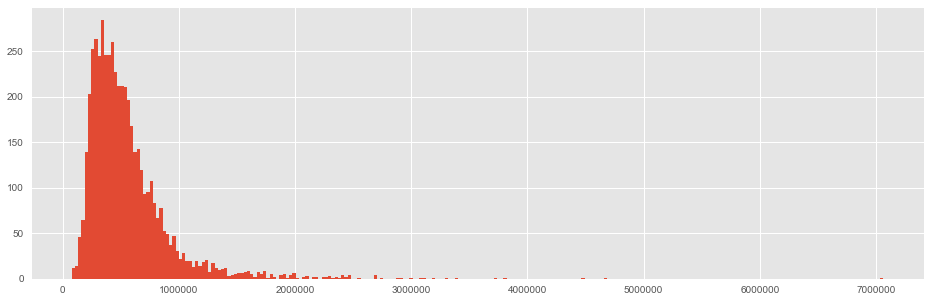

In [38]:
# We first call the original price column into a histogram, to show the initial distribution. We can see that price has a
# positive skew with an extremely long tail going off to the right.
df_final['price'].hist(bins=250, figsize=(16,5))

### 5.c Plotting the data normalisation

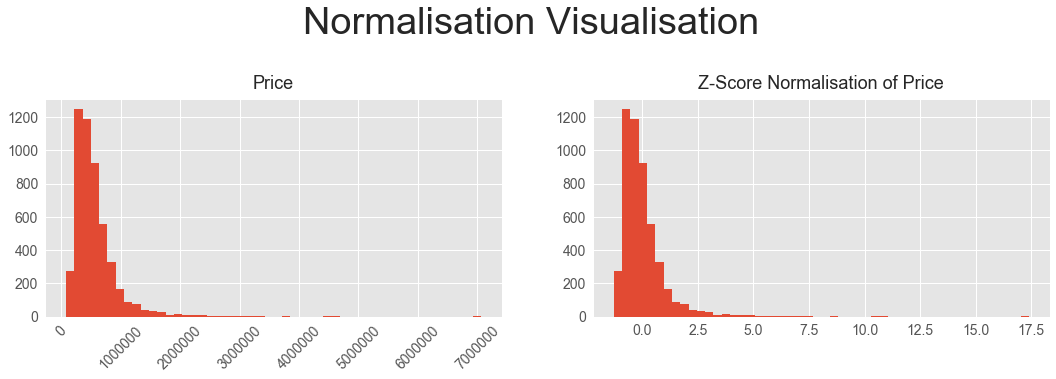

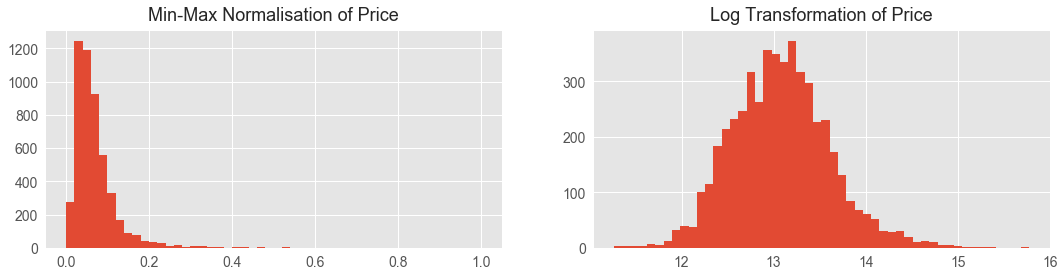

In [39]:
# Declaring consistent values for plotting
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

bars = 50
title = 38
sub_title = 18
hist1 = df_final['price']
hist2 = df_final['z_score']
hist3 = df_final['min_max']
hist4 = df_final['log_price']

######################################################################################################
# Generate the first 2 subplots, and format the meta-plot that contains the two sub-plots.
f, axarr = plt.subplots(1, 2)
f.set_size_inches(18, 4)
plt.suptitle('Normalisation Visualisation', y=1.2, size=title)
# Fill the first set of subplots
axarr[0].hist(hist1, bars)
axarr[1].hist(hist2, bars)
# Format these subplots
axarr[0].set_title('Price', size=sub_title)
axarr[1].set_title('Z-Score Normalisation of Price', size=sub_title)
plt.setp(axarr[0].get_xticklabels(), rotation=45)

######################################################################################################
# Generate the second 2 subplots, and format the meta-plot that contains the two sub-plots.
f, axarr = plt.subplots(1, 2)
f.set_size_inches(18, 4)
# Fill the second set of subplots
axarr[0].hist(hist3, bars)
axarr[1].hist(hist4, bars)
# Subplot formatting
axarr[0].set_title('Min-Max Normalisation of Price', size=sub_title)
axarr[1].set_title('Log Transformation of Price', size=sub_title)

From these plots and the table displayed previously, we can see that the Min-Max and z-score normalisations of price do not differ from the shape of the original price category; they have the same positive skew with a long right tail that price has. However, the x-values of both normalisations is significantly different compared to the parent price category. The z-score normalised price sees its standard deviation changed to one and its mean to zero, with a range of -1 to 17. Likewise the min-max normalisation sees its standard deviation changed to 0, its mean to zero, and its range to 0 to 1.

The log transformation, however, represents a significant change from the original 'price' category. The shape of the data has changed from the positive skew of price to what appears to be __approaching__ a normal - or _Gaussian_ - distribution. We note that it is __approaching__ rather than __is__ to note the fact that we cannot state for certain that it is indeed a normal distribution.

This change in the distribution from price to log price is important as Gaussian distributions are used in statistics as, in one of its more common forms, the central limit theorem states that an average of samples of observations of random variables will approach a normal distribution as the number of samples approaches infinity.

### Writing the final dataframe to CSV

In [40]:
df_final.to_csv("Farrell_28629396_ass3.csv", index=False)